In [4]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import integrate, interpolate, special
from scipy.special import psi
from scipy.stats import gengamma, laplace, norm, kstwo, ks_1samp
import matplotlib.pyplot as plt
import pickle
import os
import math
from scipy.linalg import svd
import matplotlib.pyplot as plt
from scipy.misc import derivative
import matplotlib.patches as patches
from sigfig import round

In [5]:

def derivative_r(r, eta, scale=1):
    beta = (eta + 1.5) / r

    def gauss_density(theta, x):
        return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)

    def gen_gamma_density(theta):
        return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)

    def integrand_up(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta) * math.log(theta) * theta ** r

    def integrand_down(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta)

    def integral_up(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_up(theta, x), 0, np.inf)
        return result

    def integral_down(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result

    def integral_ratio(x):
        up = integral_up(x)
        down = integral_down(x)
        return up / down if down != 0 else float('inf')  # Avoid division by zero

    psi_value = scipy.special.psi((eta + 0.5) / r) * ((eta + 0.5) / r**2)

    return lambda x: r**-1 + psi_value - integral_ratio(x)


In [6]:
def derivative_eta(r, eta, scale=1):
    beta = (eta + 1.5) / r

    def gauss_density(theta, x):
        return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)

    def gen_gamma_density(theta):
        return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)

    def integrand_up(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta) * math.log(theta)

    def integrand_down(theta, x):
        return gauss_density(theta, x) * gen_gamma_density(theta)

    def integral_up(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_up(theta, x), 0, np.inf)
        return result

    def integral_down(x):
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result

    def integral_ratio(x):
        up = integral_up(x)
        down = integral_down(x)
        return up / down if down != 0 else float('inf')  # Avoid division by zero

    psi_value = - scipy.special.psi((eta + 0.5) / r) * (1 / r)

    return lambda x: psi_value + integral_ratio(x)



In [7]:
def integrate_function_r_eta(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        dr_val = dr_func(x)
        de_val = de_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (dr_val * de_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result


In [8]:
def integrate_function_r_r(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        dr_val = dr_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (dr_val * dr_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result

In [9]:
def integrate_function_eta_eta(r, eta, scale=1):
    # Create instances of the functions that depend on x
    dr_func = derivative_r(r, eta, scale)
    de_func = derivative_eta(r, eta, scale)
    
    # Define the function for integrate_with_respect_to_theta_down from derivative_r
    # (Should ideally be the same in both derivative_r and derivative_eta to avoid duplication)
    def integral_down(x):
        beta = (eta + 1.5) / r
        def gauss_density(theta, x):
            return (1. / (np.sqrt(2 * np.pi) * theta)) * np.exp(-0.5 * (x / theta) ** 2)
        def gen_gamma_density(theta):
            return (r / scipy.special.gamma(beta)) * (1 / scale) * (theta / scale) ** (r * beta - 1) * np.exp(-(theta / scale) ** r)
        def integrand_down(theta, x):
            return gauss_density(theta, x) * gen_gamma_density(theta)
        result, error = scipy.integrate.quad(lambda theta: integrand_down(theta, x), 0, np.inf)
        return result
    
    # Define the function to be integrated over x
    def integrand(x):
        de_val = de_func(x)
        down_val = integral_down(x)
        if down_val != 0:
            return (de_val * de_val) * down_val
        else:
            return 0  # Handle division by zero if necessary

    # Perform the integration from -inf to inf
    result, error = scipy.integrate.quad(integrand, -np.inf, np.inf)
    return result

In [10]:
#r = np.linspace(0.1, 2, 20)
#eta = np.linspace(0.1, 2, 20)
#r = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
#eta = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
#R, Eta = np.meshgrid(r, eta)


# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(0, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(0, 360)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

#0.25 r=3 0.5 eta=8


C:\Users\yashd\AppData\Local\Temp\ipykernel_5792\295734941.py:14: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(0, 360)]


In [11]:
def hessian(r, eta):
        # Hessian matrix
    H = np.array([[integrate_function_r_r(r, eta), integrate_function_r_eta(r, eta)],
                  [integrate_function_r_eta(r, eta), integrate_function_eta_eta(r, eta)]])
    return H

In [12]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

C:\Users\yashd\AppData\Local\Temp\ipykernel_5792\4131166484.py:7: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
C:\Users\yashd\AppData\Local\Temp\ipykernel_5792\4131166484.py:8: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-30, 380)]


Singular Value: 0.00010386688595042408, r: 4.0, eta: 8.0
Singular Value: 0.0001113006318880988, r: 3.75, eta: 8.0
Singular Value: 0.00011977126818300338, r: 3.5, eta: 8.0
Singular Value: 0.00012955828664449777, r: 3.25, eta: 8.0
Singular Value: 0.000129695058504761, r: 4.0, eta: 7.5
Singular Value: 0.00013897558298822546, r: 3.75, eta: 7.5
Singular Value: 0.0001410508677727813, r: 3.0, eta: 8.0
Singular Value: 0.00014947277521371987, r: 3.5, eta: 7.5
Singular Value: 0.00015480312396015493, r: 2.75, eta: 8.0
Singular Value: 0.00016153945212856512, r: 3.25, eta: 7.5
Singular Value: 0.0001637894931522884, r: 4.0, eta: 7.0
Singular Value: 0.0001715602620449371, r: 2.5, eta: 8.0
Singular Value: 0.00017559098221174395, r: 3.75, eta: 7.0
Singular Value: 0.00017563192309265048, r: 3.0, eta: 7.5
Singular Value: 0.00018883437202813578, r: 3.5, eta: 7.0
Singular Value: 0.0001924186260879491, r: 2.75, eta: 7.5
Singular Value: 0.0001924498817607383, r: 2.25, eta: 8.0
Singular Value: 0.0002039416211

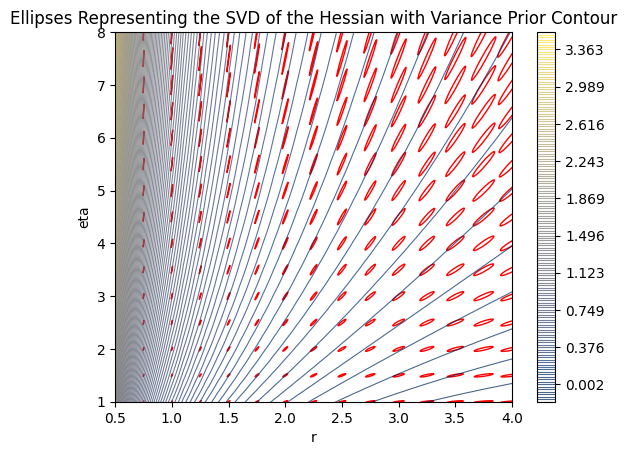

In [13]:

# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-30, 380)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Initialize the plot
fig, ax = plt.subplots()
ax.set_xlim(np.min(r_ellipses), np.max(r_ellipses))
ax.set_ylim(np.min(eta_ellipses), np.max(eta_ellipses))

scale_factor = 0.01
pos_list = []
singular_values = []

# Directory for storing Hessian matrices
hessian_dir = 'hessian_matrices'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (r, eta) pair
def get_hessian_path(r_val, eta_val):
    return os.path.join(hessian_dir, f'hessian_R{r_val}_Eta{eta_val}.pkl')

# Function to calculate variance_prior
def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5) / r
    var_prior = scale * scipy.special.gamma(beta + 1 / r) / scipy.special.gamma(beta)
    return var_prior

# Initialize grid for var_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Loop through R_ellipses and Eta_ellipses for the ellipses
for i in range(len(r_ellipses)):
    for j in range(len(eta_ellipses)):
        hessian_path = get_hessian_path(R_ellipses[i, j], Eta_ellipses[i, j])
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            # Calculate the Hessian matrix if not already stored
            H = hessian(R_ellipses[i, j], Eta_ellipses[i, j])
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        
        pos_list.append(is_pos_def(H))
        U, s, Vt = np.linalg.svd(H)
        for singular_value in s:
            if R_ellipses[i, j] != 0.25:
                singular_values.append((singular_value, R_ellipses[i, j], Eta_ellipses[i, j]))
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

# Sort the singular values in ascending order
singular_values.sort(key=lambda x: x[0])

# Print the sorted singular values and corresponding r, eta pairs
for value, r_val, eta_val in singular_values:
    print(f'Singular Value: {value}, r: {r_val}, eta: {eta_val}')

print(pos_list)

# Set upper bound for variance
upper_bound = 5

# Define contour levels using var_prior_values from the original grid
exp_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)

# Overlay contour plot with reduced opacity and no labels
contour = plt.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(exp_levels), cmap='cividis', alpha=0.7, linewidths=0.8)
plt.colorbar(contour)

# Title and labels
plt.title('Ellipses Representing the SVD of the Hessian with Variance Prior Contour')
plt.xlabel('r')
plt.ylabel('eta')
plt.show()


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_26354/4133916980.py:15: UserWarning: 2 significant figures requested from number with only 1 significant figures
  r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_26354/4133916980.py:16: UserWarning: 2 significant figures requested from number with only 1 significant figures
  eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_26354/4133916980.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/transforms.py:2070: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 0] *= sy
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/matplotlib/tra

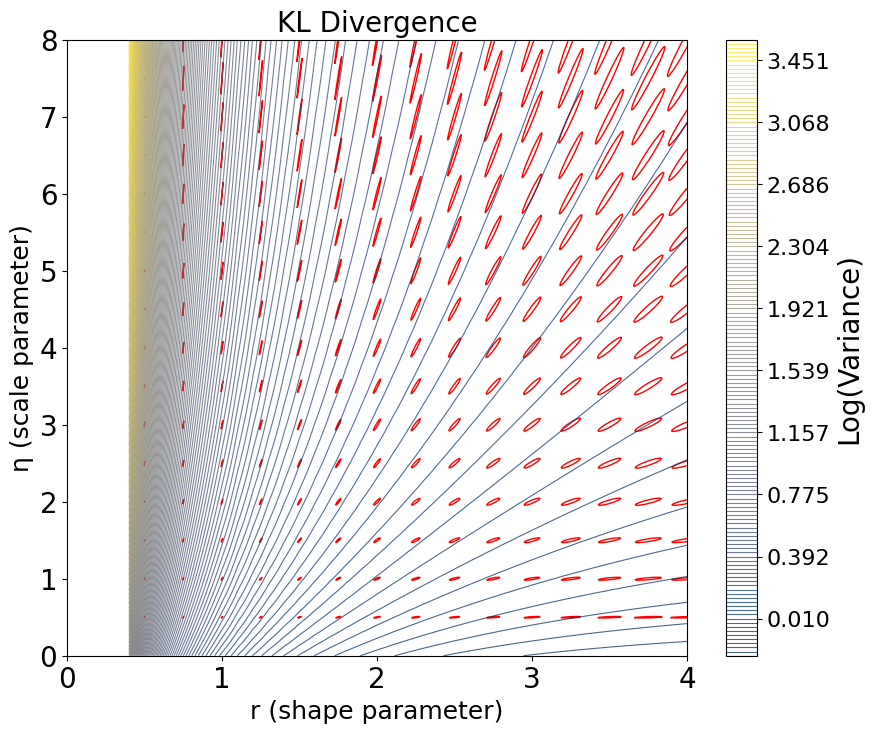

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.special
import os
import pickle
from sigfig import round

# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round(i*0.01 + 0.5, sigfigs=2) for i in range(-10, 360)]
eta_contour = [round(j*0.02 + 1, sigfigs=2) for j in range(-50, 400)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Directory for storing Hessian matrices
hessian_dir = 'hessian_matrices'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (r, eta) pair
def get_hessian_path(r_val, eta_val):
    return os.path.join(hessian_dir, f'hessian_R{r_val}_Eta{eta_val}.pkl')

# Function to calculate variance_prior
def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5) / r
    var_prior = scale * scipy.special.gamma(beta + 1 / r) / scipy.special.gamma(beta)
    return var_prior

# Hessian function
def hessian(r, eta):
    return np.array([[r, 0], [0, eta]])

# Example function to check if a matrix is positive definite
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

# Initialize grid for var_prior values for the contour plot
var_prior_values = variance_prior(R_contour, Eta_contour)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('r (shape parameter)', fontsize=18)
ax.set_ylabel('η (scale parameter)', fontsize=18)
ax.set_title('KL Divergence', fontsize=20)

# Set x and y axis limits
ax.set_xlim(0, 4)
ax.set_ylim(0, 8)

# Overlay contour plot with reduced opacity and no labels
log_levels = np.logspace(np.log10(np.min(var_prior_values)), np.log10(np.max(var_prior_values)), 150)
contour = ax.contour(R_contour, Eta_contour, np.log10(var_prior_values), levels=np.log10(log_levels), cmap='cividis', alpha=0.7, linewidths=0.8)

# Add colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Log(Variance)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Plot ellipses
scale_factor = 0.01
rows, cols = R_ellipses.shape  # Get correct dimensions of the meshgrid

for i in range(rows):  # Loop over rows
    for j in range(cols):  # Loop over columns
        hessian_path = get_hessian_path(R_ellipses[i, j], Eta_ellipses[i, j])
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            print(i, j)
            # Calculate the Hessian matrix if not already stored
            H = hessian(R_ellipses[i, j], Eta_ellipses[i, j])
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        
        U, s, Vt = np.linalg.svd(H)
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20)

# Show the plot
plt.show()
fig.savefig('plots/kl_divergence_plot.png', bbox_inches='tight')